# **Disaster Tweets Prediction**
<a href="https://www.kaggle.com/c/nlp-getting-started/data"> Click here to access Dataset from Kaggle</a>

## **Competition Description**
  
Twitter has become an important communication channel in times of emergency.
  
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:
  
The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

##  **The Goal**

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
  
You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

## **What is Classification?**

The Classification algorithm is a Supervised Learning technique that is used to identify the category of new observations on the basis of training data. 
  
In Classification, a program learns from the given dataset or observations and then classifies new observation into a number of classes or groups. Such as, Yes or No, 0 or 1, Spam or Not Spam, cat or dog, etc. Classes can be called as targets/labels or categories.
  
The best example of an ML classification algorithm is Email Spam Detector.

The main goal of the Classification algorithm is to identify the category of a given dataset, and these algorithms are mainly used to predict the output for the categorical data.

Classification algorithms can be better understood using the below diagram. In the below diagram, there are two classes, class A and Class B. These classes have features that are similar to each other and dissimilar to other classes.

![image](https://user-images.githubusercontent.com/62233992/142577145-98cfe492-6a0c-48d7-838f-c0db0e004503.png)


### Importing required Libraries.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam



Using TensorFlow backend.


In [ ]:
import os
#os.listdir('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt')

## Loading the data and getting basic idea 

In [ ]:
tweet= pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [ ]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


## Class distribution

Before we begin with anything else,let's check the class distribution.There are only two classes 0 and 1.

Text(0, 0.5, 'samples')

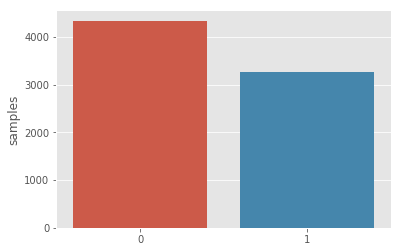

In [ ]:
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

ohh,as expected ! There is a class distribution.There are more tweets with class 0 ( No disaster) than class 1 ( disaster tweets)

## Exploratory Data Analysis of tweets

First,we will do very basic analysis,that is character level,word level and sentence level analysis.

### Number of characters in tweets

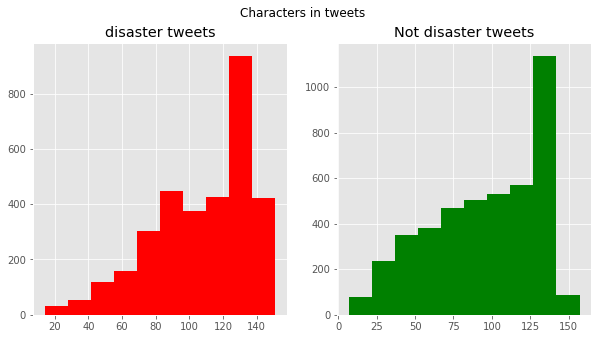

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()


The distribution of both seems to be almost same.120 t0 140 characters in a tweet are the most common among both.

### Number of words in a tweet

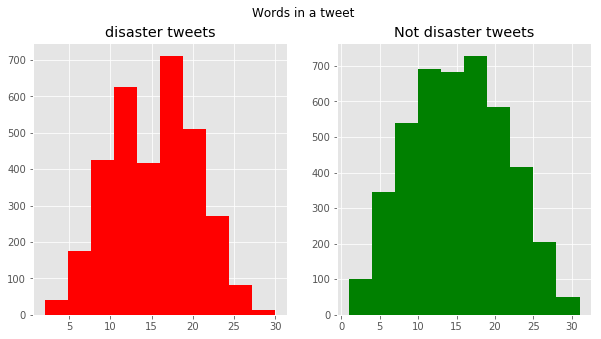

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()


###  Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

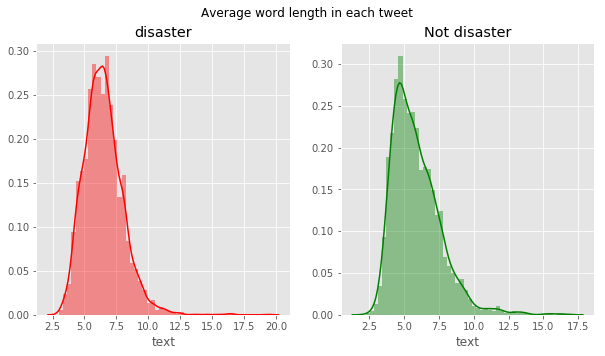

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [ ]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### Common stopwords in tweets

First we  will analyze tweets with class 0.

In [ ]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 


<BarContainer object of 10 artists>

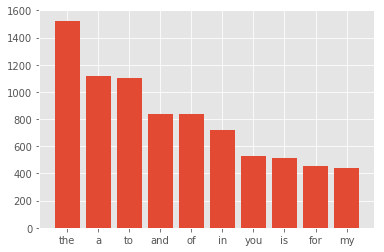

In [ ]:
x,y=zip(*top)
plt.bar(x,y)

Now,we will analyze tweets with class 1.

<BarContainer object of 10 artists>

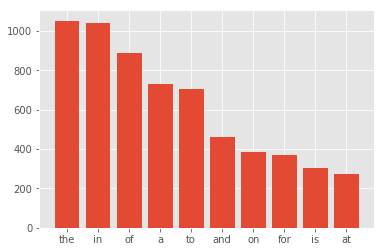

In [ ]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

In both of them,"the" dominates which is followed by "a" in class 0 and "in" in class 1.

### Analyzing punctuations.

First let's check tweets indicating real disaster.

<BarContainer object of 18 artists>

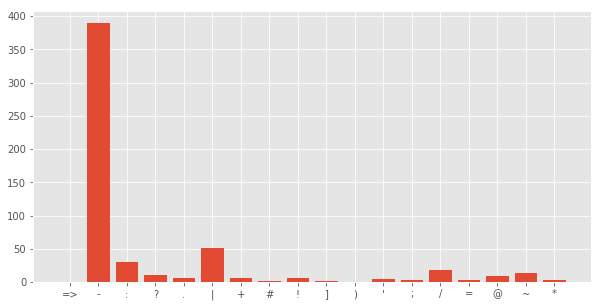

In [ ]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

Now,we will move on to class 0.

<BarContainer object of 20 artists>

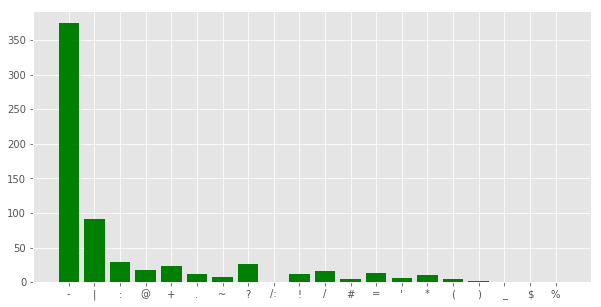

In [ ]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

### Common words ?

In [ ]:

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

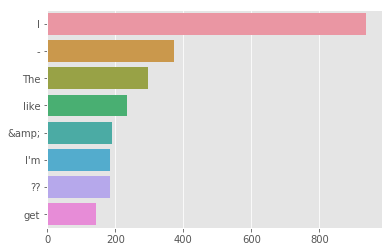

In [ ]:
sns.barplot(x=y,y=x)

Lot of cleaning needed !

### Ngram analysis

we will do a bigram (n=2) analysis over the tweets.Let's check the most common bigrams in tweets.

In [ ]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

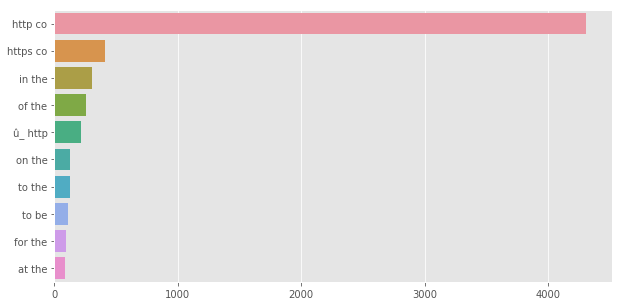

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

We will need lot of cleaning here..

## Data Cleaning
As we know,twitter tweets always have to be cleaned before we go onto modelling.So we will do some basic cleaning such as spelling correction,removing punctuations,removing html tags and emojis etc.So let's start.

In [ ]:
df=pd.concat([tweet,test])
df.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(10876, 5)

### Removing urls

In [ ]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [ ]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

### Removing HTML tags

In [ ]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [ ]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [ ]:
df['text']=df['text'].apply(lambda x : remove_html(x))

### Romoving Emojis

In [ ]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [ ]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))


### Removing punctuations

In [ ]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [ ]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

### Spelling Correction


Even if I'm not good at spelling I can correct it with python :) I will use `pyspellcheker` to do that.

In [ ]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 3.4MB/s 


In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me please'

In [ ]:
#df['text']=df['text'].apply(lambda x : correct_spellings(x)#)

## GloVe for Vectorization

Here we will use GloVe pretrained corpus model to represent our words.It is available in 3 varieties :50D ,100D and 200 Dimentional.We will try 100 D here.

In [ ]:

def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
        
        

In [ ]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:03<00:00, 3606.29it/s]


In [ ]:
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [ ]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec
            

100%|██████████| 20342/20342 [00:00<00:00, 268298.50it/s]


## Baseline Model

In [ ]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [ ]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [ ]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
 - 44s - loss: 0.6913 - accuracy: 0.5705 - val_loss: 0.6890 - val_accuracy: 0.5630
Epoch 2/15
 - 42s - loss: 0.6602 - accuracy: 0.6007 - val_loss: 0.5953 - val_accuracy: 0.7426
Epoch 3/15
 - 43s - loss: 0.5947 - accuracy: 0.7204 - val_loss: 0.5436 - val_accuracy: 0.7662
Epoch 4/15
 - 43s - loss: 0.5744 - accuracy: 0.7362 - val_loss: 0.5251 - val_accuracy: 0.7680
Epoch 5/15
 - 41s - loss: 0.5555 - accuracy: 0.7515 - val_loss: 0.5195 - val_accuracy: 0.7785
Epoch 6/15
 - 41s - loss: 0.5587 - accuracy: 0.7464 - val_loss: 0.5105 - val_accuracy: 0.7750
Epoch 7/15
 - 41s - loss: 0.5512 - accuracy: 0.7490 - val_loss: 0.5068 - val_accuracy: 0.7750
Epoch 8/15
 - 41s - loss: 0.5397 - accuracy: 0.7589 - val_loss: 0.5045 - val_accuracy: 0.7793
Epoch 9/15
 - 41s - loss: 0.5399 - accuracy: 0.7592 - val_loss: 0.5026 - val_accuracy: 0.7828
Epoch 10/15
 - 41s - loss: 0.5391 - accuracy: 0.7561 - val_loss: 0.4991 - val_accuracy: 0.7846
Epoch 11/15

After the 15th Epoch we have the got the accuracy as 0.7665 and val_loss as 0.4885. 

Since, the value of val_loss is gradually decreasing this proves that our model is performing good and that it is has a good accuracy.

## Making our submission

  Various classification models have been successfully applied on the given dataset...
  
  The different models can be evaluated using F1 between the predicted and expected answers
  
  F1 is calculated as follows:
  
  ![image](https://user-images.githubusercontent.com/62233992/142583358-6bf8f257-811e-436a-ab5e-2558987893d2.png)

  where, 
  
  ![image](https://user-images.githubusercontent.com/62233992/142583387-3fc69aea-e772-4a2a-bcea-c6e515d43aaa.png)
  
  
      - True Positive [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!
      - False Positive [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.
      - False Negative [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.
  
  The final results are predicted using our Model because of it has the best accuracy of 0.7665 which is pretty good.

In [ ]:
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [ ]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)


The submission dataframe is as given below and contains all for each ID in the test set, we must predict 1 if the tweet is describing a real disaster, and 0 otherwise. Our submission dataframe is:

In [ ]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## Conclusion

Various classification models have been successfully applied on the given dataset...

The different models can be evaluated using F1 between the predicted and expected answers

F1 is calculated as follows:

  ![image](https://user-images.githubusercontent.com/62233992/142583358-6bf8f257-811e-436a-ab5e-2558987893d2.png)

* The final results are predicted using our Model because of it has the best accuracy of 0.7665 which is pretty good.

* The submission dataframe is as given below and contains all for each ID in the test set, we must predict 1 if the tweet is describing a real disaster, and 0 otherwise. 

* Our Submission contains the following things:

![image](https://user-images.githubusercontent.com/62233992/142584758-1d13c06a-4091-4af8-b952-3fe73b3be5a4.png)




